In [2]:
!pip install python-chess
import chess
import numpy as np

def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    board_str = str(board)
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/train.csv"

train_df = pd.read_csv(file_path)

train_df.to_csv("/content/drive/My Drive/train.csv", index=False)

train_df.head()

Mounted at /content/drive


,id,board,black_score,best_move
0,80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
1,18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
2,11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
3,72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
4,74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [4]:
def count_material(fen):
    total_material = 0
    material_dict = {
        'p': 1,
        'b': 3,
        'n': 3,
        'r': 5,
        'q': 9
    }
    for char in fen.lower():
        if char in material_dict:
            total_material += material_dict[char]

    return total_material

train_df['total_material'] = train_df['board'].apply(count_material)

In [5]:

endgame_df = train_df[train_df['total_material'] < 30]
midgame_df = train_df[(30 <= train_df['total_material']) & (train_df['total_material'] <= 60)]
opening_df = train_df[(60 < train_df['total_material']) & (train_df['total_material'] <= 78)]

In [6]:
import numpy as np
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [7]:
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def generate_model(data_to_train_on, model_name):
    val_df = data_to_train_on[-1000:]
    train_df = data_to_train_on[:55000]

    X_train = np.stack(train_df['board'].apply(encode_fen_string))
    y_train = train_df['black_score']

    X_val = np.stack(val_df['board'].apply(encode_fen_string))
    y_val = val_df['black_score']

    model = Sequential([
        Flatten(),
        Dense(768, activation='relu'),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='linear'),
        BatchNormalization(),
        Dense(1),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='mean_squared_error')

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3)
    ]

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    import matplotlib.pyplot as plt

    plt.style.use('ggplot')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss During Training')
    plt.show()

    # Save the model
    model.save('/content/drive/My Drive/' + model_name + '.h5')

    return model



Epoch 1/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 167454.1250 - val_loss: 85451.7500 - learning_rate: 0.0010
Epoch 2/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 98652.8906 - val_loss: 70817.2188 - learning_rate: 0.0010
Epoch 3/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 87591.2734 - val_loss: 86098.2891 - learning_rate: 0.0010
Epoch 4/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 71568.8359 - val_loss: 66172.1016 - learning_rate: 0.0010
Epoch 5/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 75410.8750 - val_loss: 53437.6484 - learning_rate: 0.0010
Epoch 6/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 68968.0469 - val_loss: 61470.4844 - learning_rate: 0.0010
Epoch 7/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 59489.6484 - val_loss: 53730.1836 - learning_rate: 0.0010
Epoch 8/100
786/786 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 58762.2812 - val_loss: 69192.2031 - learning_rate: 0.0010
Epoch 9/100
786/786 ━━━━━━━━━━━

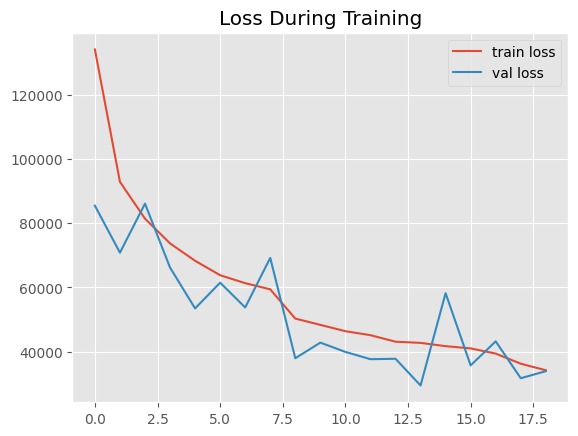

In [8]:
endgame_model = generate_model(endgame_df, 'endgame_model')

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 157057.7969 - val_loss: 100255.9766 - learning_rate: 0.0010
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 87194.0312 - val_loss: 70380.9688 - learning_rate: 0.0010
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 64228.5586 - val_loss: 53264.8086 - learning_rate: 0.0010
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 55322.3281 - val_loss: 52898.1016 - learning_rate: 0.0010
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 50629.1875 - val_loss: 55417.2773 - learning_rate: 0.0010
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 49411.1289 - val_loss: 39658.1953 - learning_rate: 0.0010
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 45616.0430 - val_loss: 41881.0469 - learning_rate: 0.0010
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 41633.6055 - val_loss: 40062.6133 - learning_rate: 0.0010
Epoch 9/100
516/516 ━━━━━━━━━━━

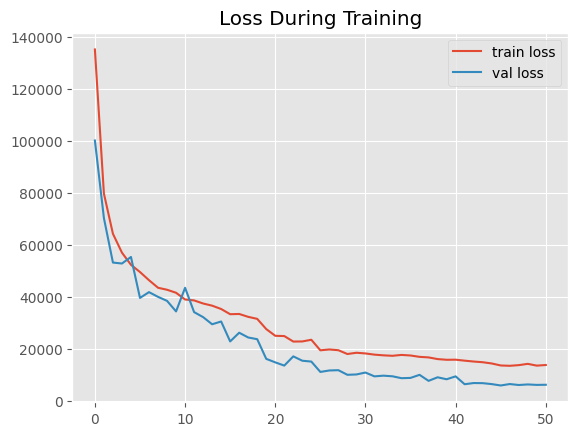

In [9]:
midgame_model = generate_model(midgame_df, 'midgame_model')

Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 144003.4688 - val_loss: 117680.2812 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 93118.8203 - val_loss: 64292.0312 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 56634.5391 - val_loss: 48508.6992 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 42204.2070 - val_loss: 59816.5547 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 37746.2422 - val_loss: 38606.8359 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 34566.5039 - val_loss: 34909.2344 - learning_rate: 0.0010
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 31960.3613 - val_loss: 38253.9219 - learning_rate: 0.0010
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 31558.5859 - val_loss: 28975.7441 - learning_rate: 0.0010
Epoch 9/100
244/244 ━━━━━━━━━━━━━━━━━━

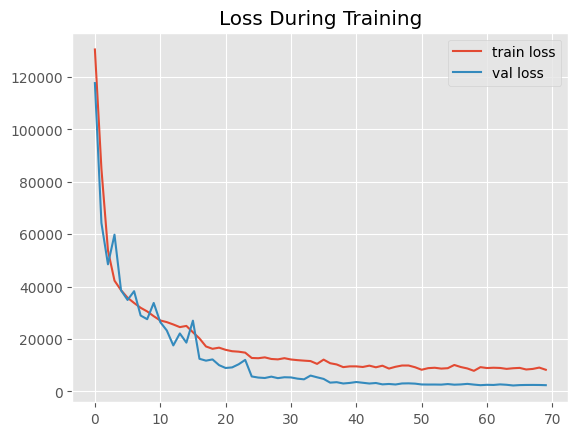

In [10]:
opening_model = generate_model(opening_df, 'opening_model')

In [ ]:
import os
from tensorflow.keras.models import load_model

def load_model_from_drive(model_path):
    drive_model_path = '/content/drive/My Drive/' + model_path
    if os.path.exists(drive_model_path):
        loaded_model = load_model(drive_model_path)
        return loaded_model
    else:
        print("Model file not found in Google Drive.")
        return None

endgame_model = load_model_from_drive("endgame_model2.h5")
midgame_model = load_model_from_drive("midgame_model2.h5")
opening_model = load_model_from_drive("opening_model.h5")

In [12]:
def play_nn(fen, depth=2):
    def evaluate(board):
        material = count_material(str(board))
        encoded_board = encode_board(board)
        reshaped_board = encoded_board.reshape(1, 8, 8, 13)
        if material < 30:
            return endgame_model.predict(reshaped_board)[0][0]
        elif material < 60:
            return midgame_model.predict(reshaped_board)[0][0]
        else:
            return opening_model.predict(reshaped_board)[0][0]

    def minimax(board, depth, alpha, beta, maximizing_player):
        if depth == 0 or board.is_game_over():
            return evaluate(board)

        legal_moves = list(board.legal_moves)

        if maximizing_player:
            max_eval = float('-inf')
            for move in legal_moves:
                board.push(move)
                eval = minimax(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in legal_moves:
                board.push(move)
                eval = minimax(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    best_move = None
    best_score = float('-inf')
    alpha = float('-inf')
    beta = float('inf')

    board = chess.Board(fen=fen)
    legal_moves = list(board.legal_moves)

    for move in legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, alpha, beta, False)
        board.pop()
        if eval > best_score:
            best_score = eval
            best_move = move
        alpha = max(alpha, eval)

    return str(best_move)


In [13]:
from IPython.display import SVG, display

def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        display(SVG(board._repr_svg_()))

        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)

    print(board.outcome())



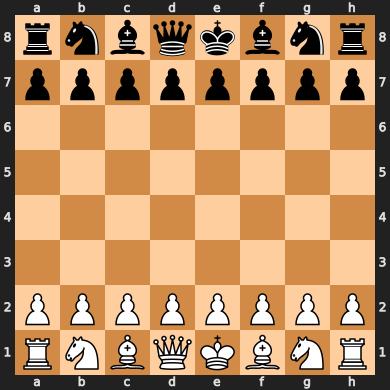

In [ ]:
play_game(play_nn)